In [50]:
import pandas as pd
import numpy as np
import os

In [51]:
with open("sent_corpus.csv", "r") as sent_file:
    lines = sent_file.read().split("\n")

In [83]:
%time rows = [line.split(",") for line in lines if line]
%time rows = [row[:3] + [",".join(row[3:])] for row in rows]
# remove document start character 
rows[0][0] = rows[0][0][1:]

sentDf_cols = ['ItemID', 'Sentiment', 'SentimentSource', 'SentimentText']


%time sentDf = pd.DataFrame(rows[1:],columns=sentDf_cols)

print(sentDf.columns.values)

sentDf[["ItemID","Sentiment"]] = sentDf[["ItemID","Sentiment"]].astype(int)
%time sentDf["SentimentText"] = sentDf["SentimentText"].apply(lambda text: text.split())

CPU times: user 3.38 s, sys: 298 ms, total: 3.68 s
Wall time: 3.73 s
CPU times: user 4.41 s, sys: 146 ms, total: 4.56 s
Wall time: 4.74 s
CPU times: user 292 ms, sys: 38.3 ms, total: 330 ms
Wall time: 330 ms
['ItemID' 'Sentiment' 'SentimentSource' 'SentimentText']
CPU times: user 4.21 s, sys: 342 ms, total: 4.56 s
Wall time: 4.7 s


In [88]:
## -*- coding: utf-8 -*-

curdir = os.getcwd()
tweet_path = curdir + "/crawler_v1/code/tweettext.txt"
print(tweet_path)

tweets = []
tweet_file = open(tweet_path, "rb")
%time 
for line in tweet_file:
#    print(line)
#    line = line_pre.decode('utf-8')
    tweet = ""
    if(line[:2] == "RT"):
        char_loc = 0
        for char in line:
            char_loc += 1
            if(char==":"):
                break

        tweet = line[-(len(line)-char_loc):]
    else:
        tweet = line
    tweets.append(tweet)

#[tweet.decode('utf-8') for tweet in tweets]
print(tweets)

print("done")

/Users/Jonny/Documents/UCLA/CS145/cs145_project/crawler_v1/code/tweettext.txt
CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 9.06 µs
[' @markdeleon77 This is just one of our undying support &amp; love for these two wonderful personality who we dearly love because\xe2\x80\xa6\n', ' #WATCH the 50th Episode of #KalingaBandhu today at 5 PM on #KalingaTV \n', 'Thanking the viewers for all the support and love\xe2\x80\xa6\n', 'There are no words to describe how lucky I am to be celebrating 8 years together in New York with @TheRealCarla. Sh\xe2\x80\xa6 https://t.co/fUts8IsCTk\n', '@kamisige__LOVE (  \xcb\x99\xe2\x97\x8a\xcb\x99  )\xef\xbe\x8e\xef\xbd\xb4?\n', '@Oo10__Sz \n', '\xe3\x81\xad\xe3\x81\x87\xe3\x81\x84\xe3\x81\xa4\xe3\x82\x84\xe3\x82\x81\xe3\x82\x8b\xe3\x81\xae\xef\xbc\x9f\n', '\xe3\x82\xa4\xe3\x83\xb3\xe3\x82\xb9\xe3\x82\xbf\xe7\xb9\x8b\xe3\x81\x8c\xe3\x82\x8a\xe3\x81\x9f\xe3\x81\x84\xe2\x80\xa6\n', 'I just love romantic animes \xf0\x9f\x98\xad\xf0\x9f\x92\x96\n', ' Thank

In [54]:
import gensim
%time w2vM = gensim.models.Word2Vec(sentDf["SentimentText"])
# %time w2vM_google = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

CPU times: user 5min 23s, sys: 7.96 s, total: 5min 31s
Wall time: 2min 18s


In [55]:
# number of samples to aggregate
Ns = int(1e5)

In [89]:
%%time
# MEAN AGGREGATION
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in sentDf["SentimentText"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

# print(tvecs[:5])
print("prediction vecs...")

tvecs_predict = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in tweets[:Ns]])

# print(tvecs_predict[:5])

prediction vecs...
CPU times: user 8.1 s, sys: 122 ms, total: 8.22 s
Wall time: 8.57 s


In [57]:
# number of samples to train on
N = int(1e5)
X = tvecs[:N]
y = sentDf["Sentiment"][:N].values
# inverse classifier
# y = 1 - y

In [58]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

In [59]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

In [60]:
def roc_auc(clf,X,y):
    probs = clf.predict_proba(X[pidx])
    fpr, tpr, thresholds = roc_curve(y[pidx], probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

In [61]:
def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

In [62]:
def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

CPU times: user 4.16 s, sys: 111 ms, total: 4.27 s
Wall time: 4.65 s
TEST
('Accuracy', 0.66608443956482688, 'Precision', 0.66868878818886124, 'Recall', 0.8091447775714159, 'F1', 0.73224218656208728)
CPU times: user 27.1 ms, sys: 8.93 ms, total: 36 ms
Wall time: 33.6 ms
TRAIN
('Accuracy', 0.67852229809159348, 'Precision', 0.67708921384735854, 'Recall', 0.82340826043627502, 'F1', 0.74311468201622899)
CPU times: user 97.4 ms, sys: 20 ms, total: 117 ms
Wall time: 115 ms
ROC AUC


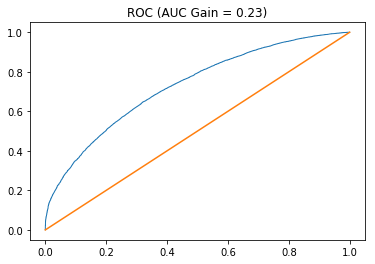

CPU times: user 184 ms, sys: 11.5 ms, total: 195 ms
Wall time: 196 ms
PRECISION/RECALL AUC


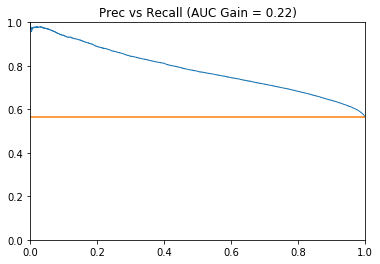

CPU times: user 275 ms, sys: 26.5 ms, total: 301 ms
Wall time: 297 ms


In [63]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
%time rf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(rf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(rf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(rf,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(rf,X,y)

In [64]:
mlp = sklearn.neural_network.MLPClassifier()
%time mlp.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(mlp,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(mlp,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(mlp,X,y)

print("PRECISION/RECALL AUC")
%time prrc_auc(mlp,X,y)

# qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
# clf = qda
# %time clf.fit(X[tidx],y[tidx])

# print("TEST")
# %time evaluate(clf,X[pidx],y[pidx])

# print("TRAIN")
# %time evaluate(clf,X[tidx],y[tidx])

# # print("ROC AUC")
# # %time roc_auc(clf,X,y)

# # print("PRECISION/RECALL AUC")
# # %time prrc_auc(clf,X,y)

In [90]:
%time sent_pred = mlp.predict(tvecs_predict[:N])

np.mean(sent_pred)

aggregated_val = 0.0
for val in sent_pred:
    aggregated_val += float(val)

aggregated_val /= len(sent_pred)


CPU times: user 771 µs, sys: 884 µs, total: 1.65 ms
Wall time: 709 µs


In [91]:
print(sent_pred)
print(aggregated_val)

[1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1]
0.83
